<a href="https://colab.research.google.com/github/murph1234/Neural-Style-Transfer/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# import numpy, tensorflow and matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

# import VGG 19 model and keras Model API
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

In [2]:

content_path = 'website.jpg'
style_path = 'style.jpg'

In [3]:
# code to load and process image
def load_and_process_image(image_path):
	img = load_img(image_path)
	# convert image to array
	img = img_to_array(img)
	img = preprocess_input(img)
	img = np.expand_dims(img, axis=0)
	return img


In [4]:


def deprocess_image(image):
    # Undo the preprocessing step by adding the mean pixel values back to the image
    image[:, :, 0] += 103.939
    image[:, :, 1] += 116.779
    image[:, :, 2] += 123.68
    # Convert the image from BGR to RGB
    image = image[:, :, ::-1]
    # Clip the values to be in the range [0, 255] and convert to unsigned 8-bit integer
    image = np.clip(image, 0, 255).astype('uint8')
    return image

def display_image(image):
    # If the image has a batch dimension (4 dimensions), remove it
    if len(image.shape) == 4:
        image = np.squeeze(image, axis=0)

    image = deprocess_image(image)

    # Turn off the grid, x-ticks, and y-ticks
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    # Display the image
    plt.imshow(image)
    return


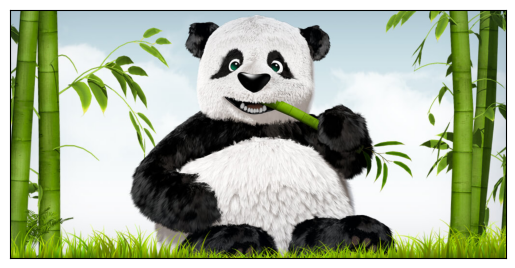

In [5]:
# load content image
content_img = load_and_process_image(content_path)
display_image(content_img)

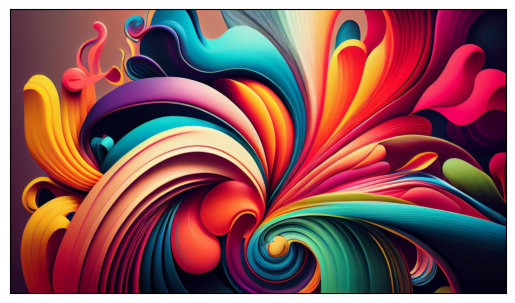

In [6]:


# load style image
style_img = load_and_process_image(style_path)
display_image(style_img)


In [7]:
# Function to download and initialize the VGG19 model
def initialize_vgg_model():
    # Load the VGG19 model with pre-trained ImageNet weights, excluding the top layers
    model = VGG19(include_top=False, weights='imagenet')
    # Disable training for the model
    model.trainable = False
    # Print a summary of the model layers
    model.summary()
    return model

# Initialize the model
vgg_model = initialize_vgg_model()


80134624/80134624 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [8]:


# Define the content layer to be used
content_layer = 'block5_conv2'

# Create a new model that outputs the activations of the specified content layer
def create_content_model(base_model, layer_name):
    content_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)
    return content_model

# Initialize the content model
content_model = create_content_model(vgg_model, content_layer)
content_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [9]:
# Define the style layers to be used
style_layers = [
    'block1_conv1',
    'block3_conv1',
    'block5_conv1'
]

# Function to create style models for each specified layer
def create_style_models(base_model, layers):
    style_models = [Model(inputs=base_model.input, outputs=base_model.get_layer(layer).output) for layer in layers]
    return style_models

# Initialize the style models
style_models = create_style_models(vgg_model, style_layers)


In [10]:


# Function to compute content loss
def content_loss(content, generated):
    # Extract the features of the content and generated images using the content model
    content_features = content_model(content)
    generated_features = content_model(generated)
    # Compute the mean squared error between the content and generated features
    loss = tf.reduce_mean(tf.square(content_features - generated_features))
    return loss


In [11]:


# Function to compute the Gram matrix of a given tensor
def gram_matrix(tensor):
    # Get the number of channels in the tensor
    channels = int(tensor.shape[-1])
    # Reshape the tensor to 2D: (height * width, channels)
    reshaped_tensor = tf.reshape(tensor, [-1, channels])
    # Compute the number of elements in the first dimension
    num_elements = tf.shape(reshaped_tensor)[0]
    # Compute the Gram matrix by multiplying the reshaped tensor with its transpose
    gram = tf.matmul(reshaped_tensor, reshaped_tensor, transpose_a=True)
    # Normalize the Gram matrix by dividing by the number of elements
    return gram / tf.cast(num_elements, tf.float32)

# Assign equal weight to each style layer
weight_of_layer = 1.0 / len(style_models)


In [12]:
# Function to compute style loss
def style_loss(style, generated):
    total_style_loss = 0.0

    # Loop through each style model and compute the loss
    for style_model in style_models:
        # Extract features from the style and generated images using the style model
        style_features = style_model(style)
        generated_features = style_model(generated)
        # Compute the Gram matrices for the style and generated features
        gram_style = gram_matrix(style_features)
        gram_generated = gram_matrix(generated_features)
        # Compute the mean squared error between the Gram matrices
        loss = tf.reduce_mean(tf.square(gram_style - gram_generated))
        # Accumulate the weighted loss
        total_style_loss += loss * weight_of_layer

    return total_style_loss


In [13]:
#content loss
def content_cost(style, generated):
	J_content = 0

	for style_model in style_models:
		a_S = style_model(style)
		a_G = style_model(generated)
		GS = gram_matrix(a_S)
		GG = gram_matrix(a_G)
		content_cost = tf.reduce_mean(tf.square(GS - GG))
		J_content += content_cost * weight_of_layer

	return J_content


In [57]:
# training function
import time
generated_images = []
losses = []
content_losses = []
style_losses = []
def training_loop(content_path, style_path, iterations=500, a=10, b=1000):
    # Load content and style images
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    generated = tf.Variable(content, dtype=tf.float32)

    # Initialize the optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=7)

    best_cost = math.inf
    best_image = None


    for i in range(iterations):
        start_time_cpu = time.process_time()
        start_time_wall = time.time()

        with tf.GradientTape() as tape:
            J_content = content_cost(content, generated)
            J_style = style_loss(style, generated)
            J_total = a * J_content + b * J_style

        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])

        end_time_cpu = time.process_time()
        end_time_wall = time.time()
        cpu_time = end_time_cpu - start_time_cpu
        wall_time = end_time_wall - start_time_wall
        losses.append(J_total.numpy())
        content_losses.append(J_content.numpy())
        style_losses.append(J_style.numpy())

        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()

        print("CPU time: {:.2f} ms".format(cpu_time * 1e3))
        print("Wall time: {:.2f} ms".format(wall_time * 1e3))
        print("Iteration: {}".format(i))
        print('Total Loss: {:e}'.format(J_total))
        print('Content Loss: {:e}'.format(J_content))
        print('Style Loss: {:e}'.format(J_style))
        generated_images.append(generated.numpy())


        # plt.figure(figsize=(10, 5))
        # plt.plot(losses, label='Total Loss')
        # plt.xlabel('Iteration')
        # plt.ylabel('Loss')
        # plt.title('Loss over Iterations')
        # plt.legend()
        # plt.show()

    return best_image

In [58]:
# Train the model and get best image
final_img = training_loop(content_path, style_path)



CPU time: 1344.17 ms
Wall time: 1839.02 ms
Iteration: 0
Total Loss: 5.781297e+11
Content Loss: 0.000000e+00
Style Loss: 5.781297e+08
CPU time: 311.26 ms
Wall time: 707.09 ms
Iteration: 1
Total Loss: 4.830987e+11
Content Loss: 4.349614e+07
Style Loss: 4.826638e+08
CPU time: 305.28 ms
Wall time: 703.29 ms
Iteration: 2
Total Loss: 3.415659e+11
Content Loss: 1.975800e+08
Style Loss: 3.395901e+08
CPU time: 263.42 ms
Wall time: 691.47 ms
Iteration: 3
Total Loss: 2.805615e+11
Content Loss: 4.401892e+08
Style Loss: 2.761596e+08
CPU time: 265.62 ms
Wall time: 693.90 ms
Iteration: 4
Total Loss: 2.434297e+11
Content Loss: 5.667034e+08
Style Loss: 2.377627e+08
CPU time: 486.55 ms
Wall time: 908.63 ms
Iteration: 5
Total Loss: 2.027307e+11
Content Loss: 5.610226e+08
Style Loss: 1.971205e+08
CPU time: 261.22 ms
Wall time: 686.86 ms
Iteration: 6
Total Loss: 1.703578e+11
Content Loss: 5.194774e+08
Style Loss: 1.651630e+08
CPU time: 267.29 ms
Wall time: 695.07 ms
Iteration: 7
Total Loss: 1.470813e+11
Co

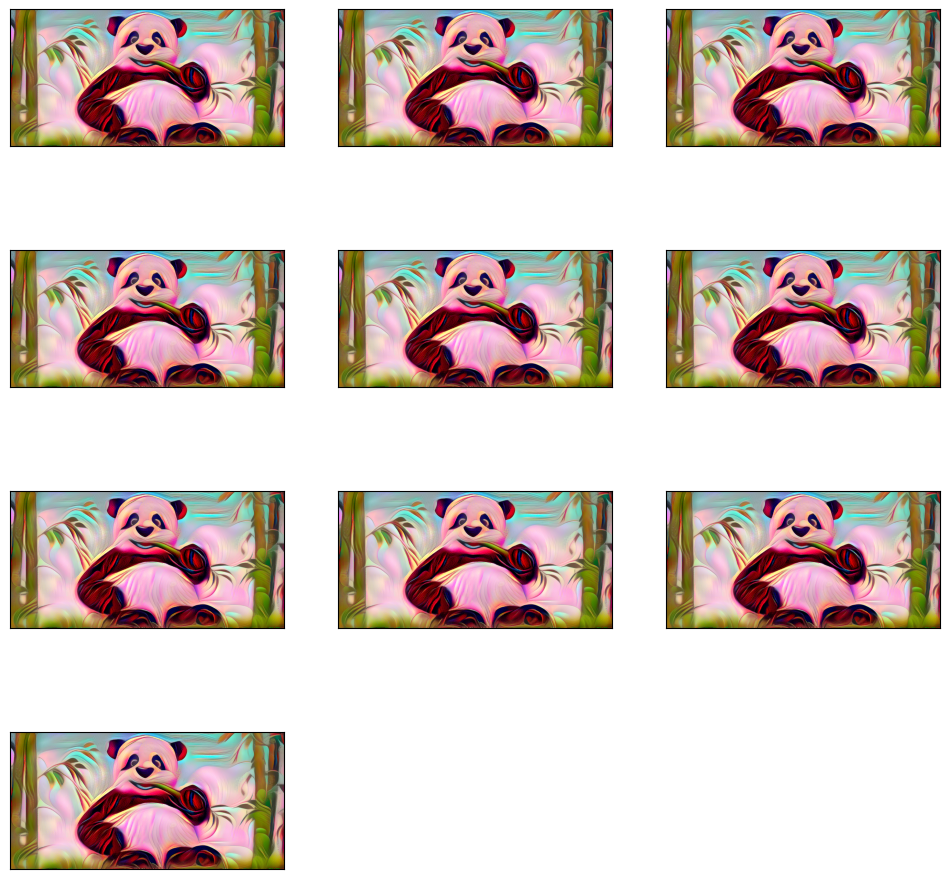

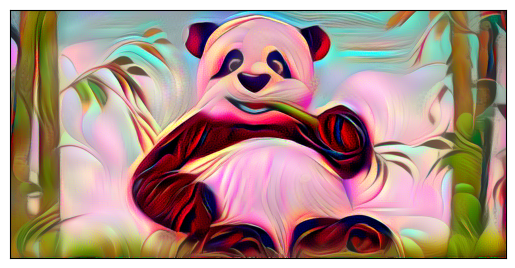

In [59]:
# code to display best generated image and last 10 intermediate results
plt.figure(figsize=(12, 12))

for i in range(10):
	plt.subplot(4, 3, i + 1)
	display_image(generated_images[i+489])
plt.show()

# plot best result
display_image(final_img)


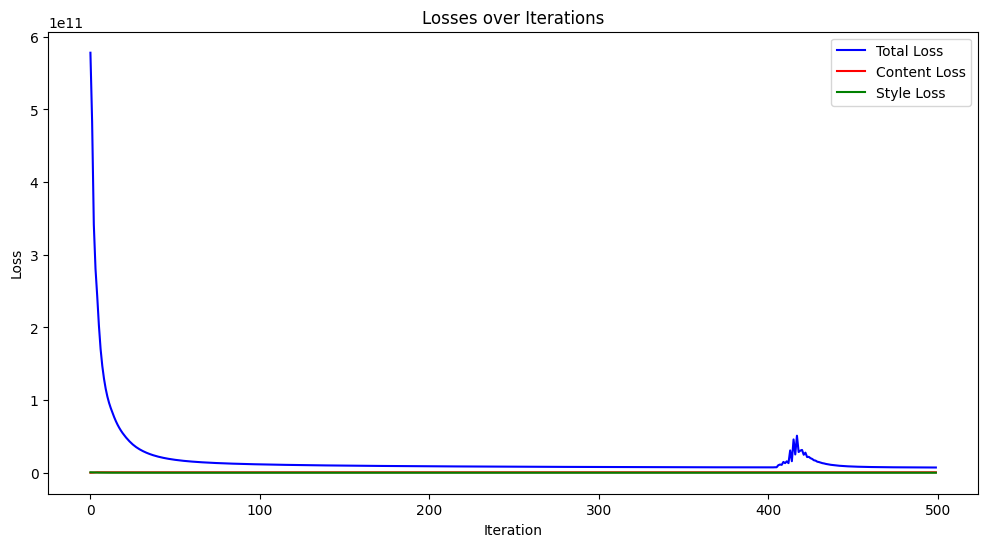

In [60]:
    plt.figure(figsize=(12, 6))

    plt.plot(losses, label='Total Loss', color='b')
    plt.plot(content_losses, label='Content Loss', color='r')
    plt.plot(style_losses, label='Style Loss', color='g')

    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Losses over Iterations')
    plt.legend()
    plt.show()